In [1]:
###Hide
import numpy as np
import pandas as pd
import scipy as sp
from sklearn import preprocessing
from sklearn.cross_validation import KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.ensemble import AdaBoostClassifier as AdaBoost
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn import grid_search
from sklearn.decomposition import PCA
from sklearn import feature_selection as fs
from sklearn.externals import joblib
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

## Tuning to Maximize Model Performance

#### Step 2.1: Get Performance Metric

In [2]:
# Load the performance metric
performance_metric = pd.read_csv('datasets/performance_metric.csv', delimiter=',')

print "Our Performance Metric is to get a better score the following:"
performance_metric

Our Performance Metric is to get a better score the following:


,KNN,LDA,QDA,RF,SVC,Tree,Unweighted Logistic,Weighted Logistic
0,0.905711,0.906115,0.847791,0.791891,0.760776,0.896013,0.908675,0.648303
1,0.990794,0.990943,0.911210,0.843207,0.794655,0.974759,0.997327,0.657313
2,0.074020,0.076923,0.227866,0.290276,0.429608,0.126270,0.042090,0.560232


#### Step 2.2: Select Top Performing Models

Pick the top 3 top performing models whos accuracy score is high in both classes. From the metric table we can see that Weighted Logistic, SVC, and Random Forest performs the best. So let take them as the base model and work towards tuning them to get better results.

#### Step 2.3: Tune Selected Model

In [3]:
# Load the clean data
ncds_data_no_indicators = pd.read_csv('datasets/ncds_data_no_indicators.csv', delimiter=',', low_memory=False)

In [4]:
# Function for computing the accuracy a given model on the entire test set,
# the accuracy on class 0 in the test set
# and the accuracy on class 1
score = lambda model, x_test, y_test: pd.Series([model.score(x_test, y_test), 
                                                 model.score(x_test[y_test==0], y_test[y_test==0]),
                                                 model.score(x_test[y_test==1], y_test[y_test==1])],
                                                index=['overall accuracy', 'accuracy on class 0', 'accuracy on class 1'])


In [5]:
# Best features
def get_best_feature(num_of_features,df,x_train, y_train):
    features = fs.SelectKBest(fs.f_regression, k=num_of_features) #k is number of features.
    features.fit(x_train, y_train)

    selected_features = features.get_support()
    selected_features_columns =  df.columns[selected_features].values
    return selected_features_columns


#### Weighted Logistic Regression Model Tuning

Tuning params with various number of predictors:


//anaconda/envs/py27/lib/python2.7/site-packages/pandas/indexes/base.py:1275: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1803 but corresponding boolean dimension is 1802
  result = getitem(key)


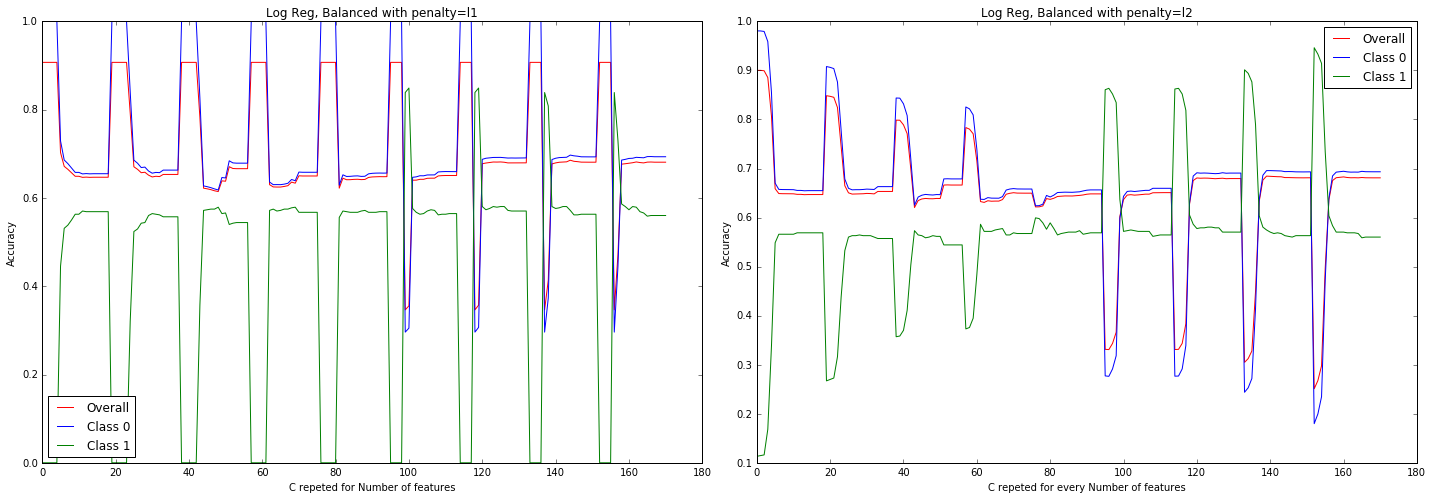

In [6]:
### Logistic Model Tuning

def tune_logistic_reg_model():
    c_list = [0.00000001,0.0000001,0.000001,0.00001,0.0001, 0.001,0.01,0.015,0.02,0.03,0.04,0.08,0.1,1,10,100,10000,100000,1000000]
    l1_overall = []
    l1_class_0 = []
    l1_class_1 = []
    l2_overall = []
    l2_class_0 = []
    l2_class_1 = []
    no_of_features = [10,15,20,25,30,35,40,45,50]
    x_index =[]
    count = 0
    x_l1_df = pd.DataFrame(columns=('x_index','Model', 'C', 'NOF', 'class0', 'class1','overall'))
    x_l2_df = pd.DataFrame(columns=('x_index','Model', 'C', 'NOF', 'class0', 'class1','overall'))
    
    for nof in no_of_features:
        # Split data for all features
        x = ncds_data_no_indicators.values[:, :-1]
        y = ncds_data_no_indicators.values[:, -1]
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)
    
    
        # Get best features
        selected_features_columns = get_best_feature(nof,ncds_data_no_indicators,x_train, y_train)

        # Split data for selected features only
        x = ncds_data_no_indicators[selected_features_columns].values[:,:]
        y = ncds_data_no_indicators.values[:, -1]

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

        for c in c_list:
            x_index.append(count)
            
            logistic = LogisticRegression(class_weight='balanced',C=c,penalty='l1')
            logistic.fit(x_train, y_train)
            logistic_scores = score(logistic, x_test, y_test)
            #print logistic_scores
            l1_overall.append(logistic_scores['overall accuracy'])
            l1_class_0.append(logistic_scores['accuracy on class 0'])
            l1_class_1.append(logistic_scores['accuracy on class 1'])
            
            x_l1_df.loc[count] = {'x_index':count,'Model':'Logistic l1', 'C':c, 'NOF':nof , 'class0':logistic_scores['accuracy on class 0'], 'class1':logistic_scores['accuracy on class 1'],'overall':logistic_scores['overall accuracy']}

            logistic = LogisticRegression(class_weight='balanced',C=c,penalty='l2')
            logistic.fit(x_train, y_train)
            logistic_scores = score(logistic, x_test, y_test)
            #print logistic_scores
            l2_overall.append(logistic_scores['overall accuracy'])
            l2_class_0.append(logistic_scores['accuracy on class 0'])
            l2_class_1.append(logistic_scores['accuracy on class 1'])
            
            
            
            x_l2_df.loc[count] = {'x_index':count,'Model':'Logistic l2', 'C':c, 'NOF':nof , 'class0':logistic_scores['accuracy on class 0'], 'class1':logistic_scores['accuracy on class 1'],'overall':logistic_scores['overall accuracy']}
            count = count +1

    # Plot the results
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))
    ax[0].plot(x_index,l1_overall,color='r',label='Overall')
    ax[0].plot(x_index,l1_class_0,color='b',label='Class 0')
    ax[0].plot(x_index,l1_class_1,color='g',label='Class 1')
    ax[0].set_title("Log Reg, Balanced with penalty=l1")
    ax[0].set_xlabel('C repeted for Number of features')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(loc = 'best')

    ax[1].plot(x_index,l2_overall,color='r',label='Overall')
    ax[1].plot(x_index,l2_class_0,color='b',label='Class 0')
    ax[1].plot(x_index,l2_class_1,color='g',label='Class 1')
    ax[1].set_title("Log Reg, Balanced with penalty=l2")
    ax[1].set_xlabel('C repeted for every Number of features')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc = 'best')

    plt.tight_layout()
    plt.show()
    
    return x_l1_df , x_l2_df


# Tune without standarization
print "Tuning params with various number of predictors:"
tune_params_l1 , tune_params_l2 = tune_logistic_reg_model()

In [7]:
# Logistic with l1 penalty
tune_params_l1['sum'] = tune_params_l1['class0'] + tune_params_l1['class1']
tune_params_l1.sort_values(['sum'], ascending=[False]).head(10)

,x_index,Model,C,NOF,class0,class1,overall,sum
143,143.0,Logistic l1,0.04,45.0,0.692205,0.580552,0.681843,1.272756
125,125.0,Logistic l1,0.08,40.0,0.691908,0.580552,0.681573,1.272459
142,142.0,Logistic l1,0.03,45.0,0.691759,0.580552,0.681439,1.272311
123,123.0,Logistic l1,0.03,40.0,0.691759,0.580552,0.681439,1.272311
158,158.0,Logistic l1,0.01,50.0,0.685820,0.586357,0.676589,1.272177
126,126.0,Logistic l1,0.10,40.0,0.691166,0.580552,0.680900,1.271717
162,162.0,Logistic l1,0.04,50.0,0.692056,0.579100,0.681573,1.271157
124,124.0,Logistic l1,0.04,40.0,0.691759,0.579100,0.681304,1.270860
161,161.0,Logistic l1,0.03,50.0,0.689978,0.580552,0.679822,1.270529
141,141.0,Logistic l1,0.02,45.0,0.691463,0.577649,0.680900,1.269111


In [8]:
# Logistic with l2 penalty
tune_params_l2['sum'] = tune_params_l1['class0'] + tune_params_l1['class1']
tune_params_l2.sort_values(['sum'], ascending=[False]).head(10)

,x_index,Model,C,NOF,class0,class1,overall,sum
143,143.0,Logistic l2,0.04,45.0,0.695026,0.567489,0.683190,1.272756
125,125.0,Logistic l2,0.08,40.0,0.689532,0.579100,0.679283,1.272459
142,142.0,Logistic l2,0.03,45.0,0.695026,0.568940,0.683324,1.272311
123,123.0,Logistic l2,0.03,40.0,0.690572,0.580552,0.680361,1.272311
158,158.0,Logistic l2,0.01,50.0,0.692650,0.570392,0.681304,1.272177
126,126.0,Logistic l2,0.10,40.0,0.689978,0.579100,0.679688,1.271717
162,162.0,Logistic l2,0.04,50.0,0.692650,0.568940,0.681169,1.271157
124,124.0,Logistic l2,0.04,40.0,0.689978,0.580552,0.679822,1.270860
161,161.0,Logistic l2,0.03,50.0,0.693244,0.568940,0.681708,1.270529
141,141.0,Logistic l2,0.02,45.0,0.695471,0.567489,0.683594,1.269111


#### Random Forest Model Tuning

##### Tuning parameters for random forests
There are some important parameters for random forest that help in fine-tuning the results of the random forest models. Some of the tuning parameters considers for tuning were:
- Node size: In random forest since the forest are allowed to grow without pruning, the trees can have very few observations in the leaf nodes. In order to reduce the bias as much as possible we can control the node size by setting the 'min_samples_leaf' parameter in the random forest classifier
- Number of trees: The number of trees is usually set to large number like a few hundrudes. The parameter to set to control number of trees is 'n_estimators'. The ideal value for the number of trees will depend on the number of observations and predictors in our dataset.
- Number of predictors sampled: This parameter is important in determining how the tree grows independently and not being biased to just one or a few predictors. The parameter is set by using the 'max_features' argument.
- Maximum depth: This argument determines the maximum depth of the tree. This argument controls if we want to expand the tree down so that we have all our leaves as pure nodes.
- OOB score: The OOB score is set to True or False. It determines whether to use out-of-bag samples to estimate the generalization accuracy or not

In [11]:
# Split data for all features
x = ncds_data_no_indicators.values[:, :-1]
y = ncds_data_no_indicators.values[:, -1]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

# Random Forest
tune_params_rf = pd.DataFrame(columns=('x_index','Model', 'class0', 'class1','overall'))

rf = RandomForest(n_estimators=600,class_weight='balanced',oob_score=True,max_depth=4,criterion='gini')
rf.fit(x_train, y_train)
rf_scores = score(rf, x_test, y_test)
print "RF 1: " , "Accuracy Class 1:" , rf_scores['accuracy on class 1'] , " Class 0:" , rf_scores['accuracy on class 0']
tune_params_rf.loc[0] = {'x_index':1,'Model':'Random Forest 1', 'class0':rf_scores['accuracy on class 0'], 'class1':rf_scores['accuracy on class 1'],'overall':rf_scores['overall accuracy']}

rf = RandomForest(n_estimators=600,class_weight='balanced',oob_score=True,max_depth=4,criterion='gini',min_samples_leaf=150)
rf.fit(x_train, y_train)
rf_scores = score(rf, x_test, y_test)
print "RF 2: " , "Accuracy Class 1:" , rf_scores['accuracy on class 1'] , " Class 0:" , rf_scores['accuracy on class 0']
tune_params_rf.loc[1] = {'x_index':2,'Model':'Random Forest 2', 'class0':rf_scores['accuracy on class 0'], 'class1':rf_scores['accuracy on class 1'],'overall':rf_scores['overall accuracy']}

rf = RandomForest(n_estimators=600,class_weight='balanced',oob_score=True,max_depth=5,criterion='gini',min_samples_leaf=150)
rf.fit(x_train, y_train)
rf_scores = score(rf, x_test, y_test)
print "RF 3: " , "Accuracy Class 1:" , rf_scores['accuracy on class 1'] , " Class 0:" , rf_scores['accuracy on class 0']
tune_params_rf.loc[2] = {'x_index':3,'Model':'Random Forest 3', 'class0':rf_scores['accuracy on class 0'], 'class1':rf_scores['accuracy on class 1'],'overall':rf_scores['overall accuracy']}

rf = RandomForest(n_estimators=600,class_weight='balanced',oob_score=True,max_depth=5,criterion='gini',min_samples_leaf=200)
rf.fit(x_train, y_train)
rf_scores = score(rf, x_test, y_test)
print "RF 4: " , "Accuracy Class 1:" , rf_scores['accuracy on class 1'] , " Class 0:" , rf_scores['accuracy on class 0']
tune_params_rf.loc[3] = {'x_index':4,'Model':'Random Forest 4', 'class0':rf_scores['accuracy on class 0'], 'class1':rf_scores['accuracy on class 1'],'overall':rf_scores['overall accuracy']}

rf = RandomForest(n_estimators=600,class_weight='balanced',oob_score=True,max_depth=4,criterion='gini',min_samples_leaf=300)
rf.fit(x_train, y_train)
rf_scores = score(rf, x_test, y_test)
print "RF 5: " , "Accuracy Class 1:" , rf_scores['accuracy on class 1'] , " Class 0:" , rf_scores['accuracy on class 0']
tune_params_rf.loc[4] = {'x_index':5,'Model':'Random Forest 5', 'class0':rf_scores['accuracy on class 0'], 'class1':rf_scores['accuracy on class 1'],'overall':rf_scores['overall accuracy']}

rf = RandomForest(n_estimators=600,class_weight='balanced',oob_score=True,max_depth=4,criterion='gini',min_samples_leaf=500)
rf.fit(x_train, y_train)
rf_scores = score(rf, x_test, y_test)
print "RF 6: " , "Accuracy Class 1:" , rf_scores['accuracy on class 1'] , " Class 0:" , rf_scores['accuracy on class 0']
tune_params_rf.loc[5] = {'x_index':6,'Model':'Random Forest 6', 'class0':rf_scores['accuracy on class 0'], 'class1':rf_scores['accuracy on class 1'],'overall':rf_scores['overall accuracy']}

rf = RandomForest(n_estimators=600,class_weight='balanced',oob_score=True,max_depth=4,criterion='gini',min_samples_leaf=700)
rf.fit(x_train, y_train)
rf_scores = score(rf, x_test, y_test)
print "RF 7: " , "Accuracy Class 1:" , rf_scores['accuracy on class 1'] , " Class 0:" , rf_scores['accuracy on class 0']
tune_params_rf.loc[6] = {'x_index':7,'Model':'Random Forest 7', 'class0':rf_scores['accuracy on class 0'], 'class1':rf_scores['accuracy on class 1'],'overall':rf_scores['overall accuracy']}


RF 1:  Accuracy Class 1: 0.631349782293  Class 0: 0.940905716407
RF 2:  Accuracy Class 1: 0.696661828737  Class 0: 0.802227171492
RF 3:  Accuracy Class 1: 0.673439767779  Class 0: 0.804454342984
RF 4:  Accuracy Class 1: 0.686502177068  Class 0: 0.762286562732
RF 5:  Accuracy Class 1: 0.721335268505  Class 0: 0.677357089829
RF 6:  Accuracy Class 1: 0.719883889695  Class 0: 0.630883444692
RF 7:  Accuracy Class 1: 0.715529753266  Class 0: 0.572383073497


In [13]:
# Random forest
tune_params_rf['sum'] = tune_params_rf['class0'] + tune_params_rf['class1']
tune_params_rf.head(7)

,x_index,Model,class0,class1,overall,sum
0,1.0,Random Forest 1,0.940906,0.631350,0.912177,1.572255
1,2.0,Random Forest 2,0.802227,0.696662,0.792430,1.498889
2,3.0,Random Forest 3,0.804454,0.673440,0.792295,1.477894
3,4.0,Random Forest 4,0.762287,0.686502,0.755253,1.448789
4,5.0,Random Forest 5,0.677357,0.721335,0.681439,1.398692
5,6.0,Random Forest 6,0.630883,0.719884,0.639143,1.350767
6,7.0,Random Forest 7,0.572383,0.715530,0.585668,1.287913


#### Support Vector Classification Model Tuning

In [ ]:
no_of_features = [10,15] # 20,25,30,35,40,45,50

for nof in no_of_features:
    print "Number of features:", nof
    # Split data for all features
    x = ncds_data_no_indicators.values[:, :-1]
    y = ncds_data_no_indicators.values[:, -1]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)
    
    # Get best features
    selected_features_columns = get_best_feature(nof,ncds_data_no_indicators,x_train, y_train)

    # Split data for selected features only
    x = ncds_data_no_indicators[selected_features_columns].values[:,:]
    y = ncds_data_no_indicators.values[:, -1]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)

    # SVC
    svc = SVC(class_weight='balanced',C=100, kernel='linear')
    svc.fit(x_train, y_train)
    svc_scores = score(svc, x_test, y_test)
    print "SVC 1: " , "Accuracy Class 1:" , svc_scores['accuracy on class 1'] , " Class 0:" , svc_scores['accuracy on class 0']

    svc = SVC(class_weight='balanced',C=1000, kernel='linear')
    svc.fit(x_train, y_train)
    svc_scores = score(svc, x_test, y_test)
    print "SVC 2: " , "Accuracy Class 1:" , svc_scores['accuracy on class 1'] , " Class 0:" , svc_scores['accuracy on class 0']

    svc = SVC(class_weight='balanced',C=10000, kernel='linear')
    svc.fit(x_train, y_train)
    svc_scores = score(svc, x_test, y_test)
    print "SVC 3: " , "Accuracy Class 1:" , svc_scores['accuracy on class 1'] , " Class 0:" , svc_scores['accuracy on class 0']

Number of features: 10
SVC 1:  Accuracy Class 1: 0.513788098694  Class 0: 0.692798812175
SVC 2:  Accuracy Class 1: 0.513788098694  Class 0: 0.693244246474
SVC 3:  Accuracy Class 1: 0.513788098694  Class 0: 0.692650334076
Number of features: 15
SVC 1:  Accuracy Class 1: 0.461538461538  Class 0: 0.769413511507
SVC 2:  Accuracy Class 1: 0.461538461538  Class 0: 0.769265033408
